1. 均值回归简介

均值回归策略基于一个核心假设：资产价格会围绕其历史均值波动。如果价格偏离均值太远，未来可能会回归到均值附近。

优势：适合震荡市场，捕捉短期价格波动。

适用场景：股票、ETF等具有稳定均值的资产。

In [31]:
import akshare as ak
import pandas as pd


df = ak.stock_zh_a_hist('300059')
df.head()

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2010-03-19,300059,61.00,58.35,62.20,58.03,197373,1.182394e+09,10.28,43.79,17.77,70.49
1,2010-03-22,300059,61.10,64.19,64.19,60.26,110104,6.935957e+08,6.74,10.01,5.84,39.32
2,2010-03-23,300059,63.00,65.10,65.66,62.52,85522,5.471359e+08,4.89,1.42,0.91,30.54
3,2010-03-24,300059,65.18,68.69,71.49,64.64,72530,4.917786e+08,10.52,5.51,3.59,25.90
4,2010-03-25,300059,68.68,69.78,71.60,68.02,60225,4.190101e+08,5.21,1.59,1.09,21.51


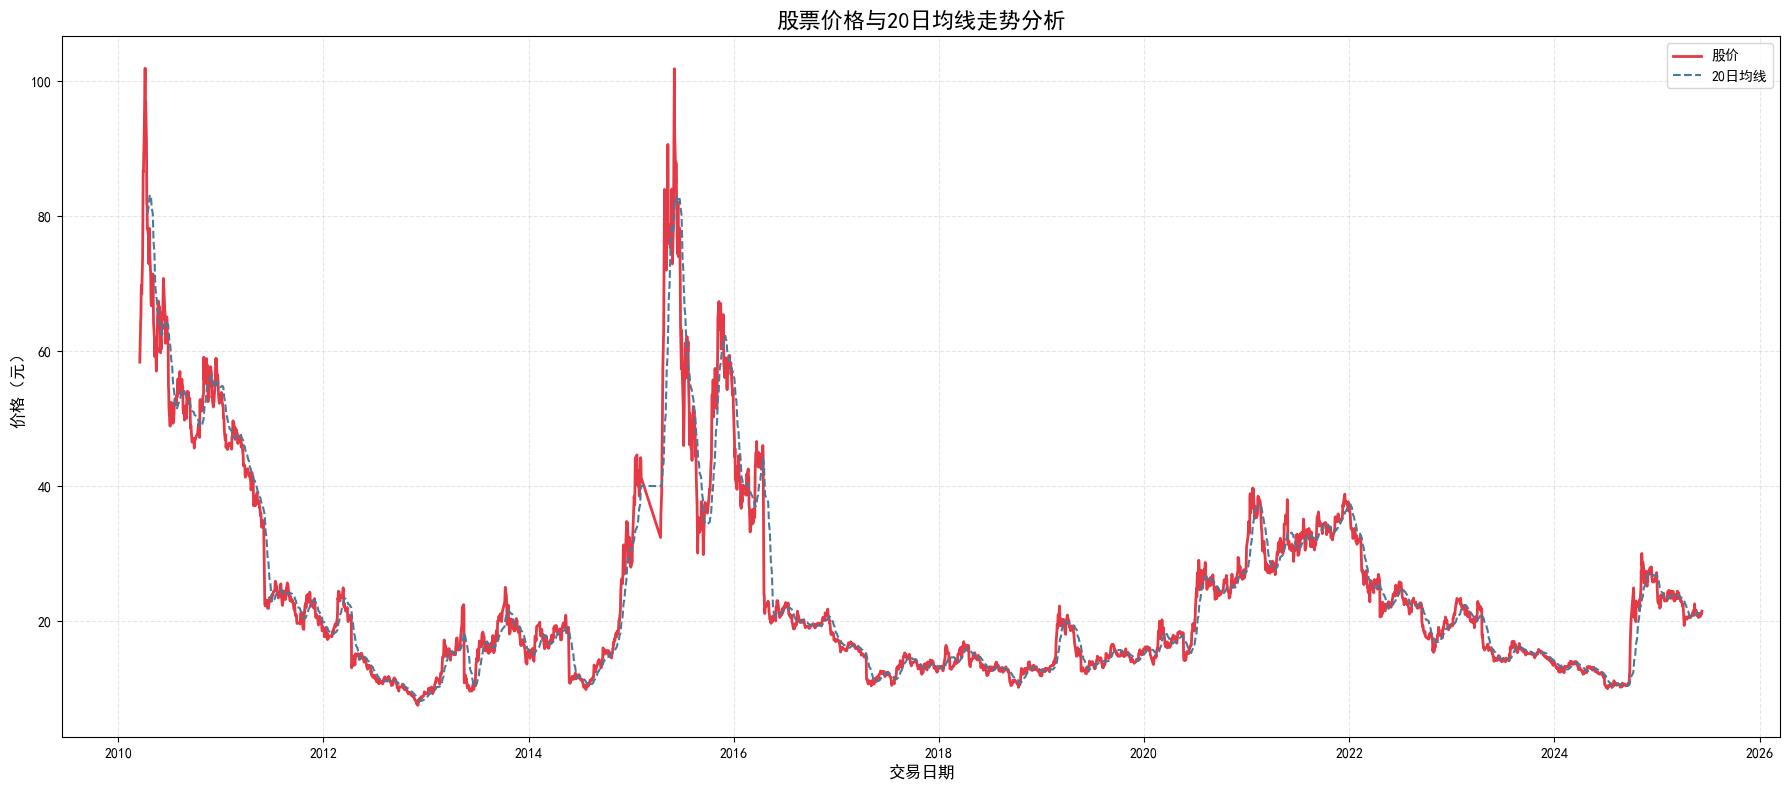

In [32]:
import matplotlib.pyplot as plt
#  计算平均线
df['MA_20'] = df['收盘'].rolling(window=20).mean()

df.set_index('日期', inplace=True)
df.index = pd.to_datetime(df.index)
plt.rcParams['font.sans-serif'] = ['SimHei']
fig, ax = plt.subplots(figsize=(18, 8))
# 绘制折线图
ax.plot(df.index, df['收盘'], label='收盘价', color='#E63946', linewidth=2)
ax.plot(df.index, df['MA_20'], label='20日均线', color='#457B9D', linewidth=1.5, linestyle='--')

# 设置标题和标签
ax.set_title('股票价格与20日均线走势分析', fontsize=16,)
ax.set_xlabel('交易日期', fontsize=12)
ax.set_ylabel('价格（元）', fontsize=12)
ax.legend(['股价', '20日均线'])

# 网格设置
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('股票价格与20日均线走势分析')
plt.show()


In [33]:
import numpy as np
def creat_sig(df):
	"""生成均值回归的交易信号

	Args:
		df (_type_): 股票的数据

	Returns:
		_type_: 返回带有交易信号的dataframe
	"""
	# 计算偏离程度
	df['Deviation'] = (df['收盘'] - df['MA_20']) / df['MA_20'] * 100
	# 平滑处理
	# 防止因为短期的变化而造成偏离
	df['Smooth_Dev'] = df['Deviation'].rolling(window=5).mean()
	
    # 计算信号时加入止损条件
	conditions = [
        (df['Smooth_Dev'] >= 15),  # 卖出信号
        (df['Smooth_Dev'] <= -15)  # 买入信号
    ]
	choices = [-1, 1]
    
	return np.select(conditions, choices, default=0)

df['sig'] = creat_sig(df)
df.head()

,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率,MA_20,Deviation,Smooth_Dev,sig
日期,,,,,,,,,,,,,,,
2010-03-19,300059,61.00,58.35,62.20,58.03,197373,1.182394e+09,10.28,43.79,17.77,70.49,NaN,NaN,NaN,0
2010-03-22,300059,61.10,64.19,64.19,60.26,110104,6.935957e+08,6.74,10.01,5.84,39.32,NaN,NaN,NaN,0
2010-03-23,300059,63.00,65.10,65.66,62.52,85522,5.471359e+08,4.89,1.42,0.91,30.54,NaN,NaN,NaN,0
2010-03-24,300059,65.18,68.69,71.49,64.64,72530,4.917786e+08,10.52,5.51,3.59,25.90,NaN,NaN,NaN,0
2010-03-25,300059,68.68,69.78,71.60,68.02,60225,4.190101e+08,5.21,1.59,1.09,21.51,NaN,NaN,NaN,0


C:\Users\79250\AppData\Local\Temp\ipykernel_21548\939015566.py:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('平滑前和平滑后的均线比较图')
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


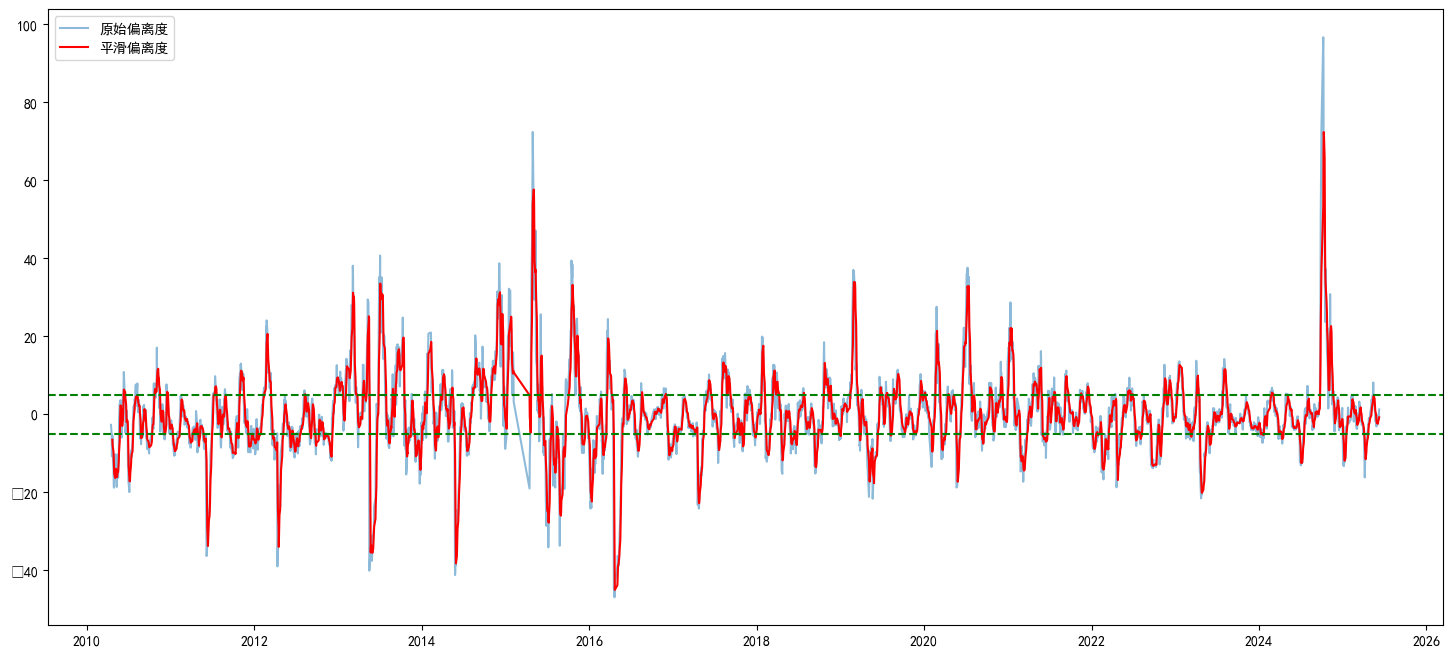

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(df.index, df['Deviation'], label='原始偏离度', alpha=0.5)
plt.plot(df.index, df['Smooth_Dev'], label='平滑偏离度', color='red')
plt.axhline(5, color='green', linestyle='--')  # 上限阈值
plt.axhline(-5, color='green', linestyle='--') # 下限阈值
plt.legend()
plt.savefig('平滑前和平滑后的均线比较图')
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def backtest_strategy(df, initial_capital=100000):
    """
    均值回归策略回测函数
    
    Args:
        df (pd.DataFrame): 包含信号和价格数据的DataFrame
        initial_capital (float): 初始资金
    
    Returns:
        dict: 回测结果统计
    """
    # 初始化变量
    capital = initial_capital  # 可用资金
    position = 0  # 当前持仓数量
    portfolio_values = []  # 资产记录
    trade_log = []  # 交易记录
    
    # 添加持仓列
    df['position'] = 0
    
    # 回测参数
    transaction_cost = 0.0003  # 交易手续费（0.03%）
    position_size = initial_capital * 0.1  # 每次交易使用资金的10%
    
    for i in range(len(df)):
        # 获取当前信号和价格
        signal = df.iloc[i]['sig']
        price = df.iloc[i]['收盘']
        
        # 记录当前总资产
        total_assets = capital + position * price
        portfolio_values.append(total_assets)
        
        # 交易逻辑
        if signal == 1 and capital > price:  # 买入信号
            # 计算可买入数量（考虑手续费）
            available_capital = min(position_size, capital)
            buy_amount = int(available_capital / (price * (1 + transaction_cost)))
            
            if buy_amount > 0:
                # 执行买入
                cost = buy_amount * price * (1 + transaction_cost)
                capital -= cost
                position += buy_amount
                
                trade_log.append({
                    'date': df.index[i],
                    'action': '买入',
                    'amount': buy_amount,
                    'price': price,
                    'cost': cost
                })
                
        elif signal == -1 and position > 0:  # 卖出信号
            # 计算可卖出数量
            sell_amount = position  # 全部卖出当前持仓
            
            # 执行卖出
            revenue = sell_amount * price * (1 - transaction_cost)
            capital += revenue
            position = 0
            
            trade_log.append({
                'date': df.index[i],
                'action': '卖出',
                'amount': sell_amount,
                'price': price,
                'revenue': revenue
            })
        
        # 更新当前持仓
        df.at[df.index[i], 'position'] = position
    
    # 计算最终持仓的市值
    final_position_value = position * df.iloc[-1]['收盘']
    final_capital = capital + final_position_value
    
    # 计算绩效指标
    final_return = (final_capital - initial_capital) / initial_capital
    max_drawdown = calculate_max_drawdown(portfolio_values)
    sharpe_ratio = calculate_sharpe_ratio(df['收盘'])
    
    # 可视化
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, portfolio_values)
    plt.title('策略净值曲线')
    plt.xlabel('日期')
    plt.ylabel('总资产')
    plt.grid(True)
    plt.savefig('回测图')
    plt.show()
    
    return {
        '初始资金': f"{initial_capital:,.2f}",
        '最终资金': f"{final_capital:,.2f}",
        '最终收益': f"{final_return*100:.2f}%",
        '最大回撤': f"{max_drawdown*100:.2f}%",
        '夏普比率': f"{sharpe_ratio:.2f}",
        '交易次数': len(trade_log),
        '交易记录': trade_log
    }

# 辅助函数：计算最大回撤
def calculate_max_drawdown(portfolio_values):
    peak = portfolio_values[0]
    max_dd = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        else:
            dd = (peak - value) / peak
            if dd > max_dd:
                max_dd = dd
    return max_dd

# 辅助函数：计算夏普比率
def calculate_sharpe_ratio(prices, risk_free_rate=0.02):
    returns = prices.pct_change().dropna()
    excess_returns = returns - risk_free_rate/252  # 日无风险收益率
    sharpe = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    return sharpe

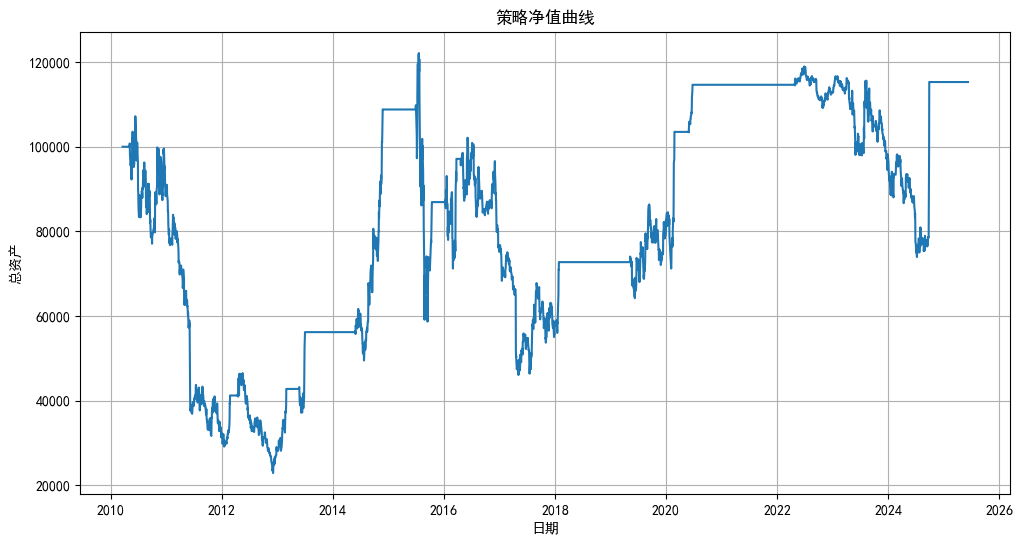

回测结果统计:
初始资金: 100,000.00
最终资金: 115,287.81
最终收益: 15.29%
最大回撤: 78.62%
夏普比率: 0.18
交易次数: 87


In [36]:
results = backtest_strategy(df)

# 打印统计结果
print("回测结果统计:")
for key, value in results.items():
    if key != '交易记录':
        print(f"{key}: {value}")

In [37]:
results

{'初始资金': '100,000.00',
 '最终资金': '115,287.81',
 '最终收益': '15.29%',
 '最大回撤': '78.62%',
 '夏普比率': '0.18',
 '交易次数': 87,
 '交易记录': [{'date': Timestamp('2010-04-30 00:00:00'),
   'action': '买入',
   'amount': 144,
   'price': 69.12,
   'cost': 9956.265984},
  {'date': Timestamp('2010-05-04 00:00:00'),
   'action': '买入',
   'amount': 146,
   'price': 68.31,
   'cost': 9976.251978},
  {'date': Timestamp('2010-05-05 00:00:00'),
   'action': '买入',
   'amount': 140,
   'price': 71.4,
   'cost': 9998.9988},
  {'date': Timestamp('2010-05-11 00:00:00'),
   'action': '买入',
   'amount': 168,
   'price': 59.2,
   'cost': 9948.58368},
  {'date': Timestamp('2010-05-12 00:00:00'),
   'action': '买入',
   'amount': 165,
   'price': 60.3,
   'cost': 9952.484849999999},
  {'date': Timestamp('2010-05-13 00:00:00'),
   'action': '买入',
   'amount': 164,
   'price': 60.8,
   'cost': 9974.191359999999},
  {'date': Timestamp('2010-05-14 00:00:00'),
   'action': '买入',
   'amount': 161,
   'price': 61.9,
   'cost': 9968.8